<a href="https://colab.research.google.com/github/nguyenthanhdat2704/GAN/blob/main/Gan_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
%matplotlib inline

In [ ]:
num_workers = 0

batch_size = 64

transform = transforms.ToTensor()

trainData = torchvision.datasets.MNIST (root='data', download = True, transform = transform, train = True)

trainLoader = torch.utils.data.DataLoader (trainData, shuffle = True, batch_size = batch_size)

***Discriminator***

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.leaky_relu(self.fc1(x), 0.2) 
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = self.fc4(x)

        return out


***Mạng Generator***

In [ ]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2) 
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = F.tanh(self.fc4(x))

        return out

In [ ]:
# Generator hyperparams
z_size = 100
g_output_size = 784
g_hidden_size = 32
# Discriminator hyperparams
input_size = 784
d_output_size = 1
d_hidden_size = 32

In [ ]:
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

print(D)
print()
print(G)


Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


***Loss Function***


In [ ]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [ ]:
# Tách biệt generator và discriminator
lr = 0.002
g_optimizer = optim.Adam(G.parameters(), lr)
d_optimizer = optim.Adam(D.parameters(), lr)

***Training***

In [ ]:
import pickle as pkl

num_epochs = 100

samples = []
losses = []

print_every = 400

sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(trainLoader):
                
        batch_size = real_images.size(0)
         
        real_images = real_images*2 - 1  

        d_optimizer.zero_grad()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)
              
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        g_optimizer.zero_grad()
        
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
      
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) 
        
        g_loss.backward()
        g_optimizer.step()

        if batch_i % print_every == 0:
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    losses.append((d_loss.item(), g_loss.item()))
    
    G.eval() 
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() 
    
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.3647 | g_loss: 0.7297
Epoch [    1/  100] | d_loss: 0.6130 | g_loss: 5.5577
Epoch [    1/  100] | d_loss: 1.0465 | g_loss: 1.4477
Epoch [    2/  100] | d_loss: 1.4967 | g_loss: 2.1150
Epoch [    2/  100] | d_loss: 1.1412 | g_loss: 1.6806
Epoch [    2/  100] | d_loss: 1.0406 | g_loss: 1.7849
Epoch [    3/  100] | d_loss: 1.0387 | g_loss: 1.7696
Epoch [    3/  100] | d_loss: 1.0771 | g_loss: 1.1454
Epoch [    3/  100] | d_loss: 1.1612 | g_loss: 1.5473
Epoch [    4/  100] | d_loss: 1.2092 | g_loss: 1.0748
Epoch [    4/  100] | d_loss: 1.1183 | g_loss: 1.1050
Epoch [    4/  100] | d_loss: 0.9663 | g_loss: 2.8708
Epoch [    5/  100] | d_loss: 1.2191 | g_loss: 1.3341
Epoch [    5/  100] | d_loss: 1.2023 | g_loss: 1.3922
Epoch [    5/  100] | d_loss: 1.2051 | g_loss: 1.5116
Epoch [    6/  100] | d_loss: 1.2955 | g_loss: 0.9108
Epoch [    6/  100] | d_loss: 1.2577 | g_loss: 1.3438
Epoch [    6/  100] | d_loss: 1.1816 | g_loss: 2.0620
Epoch [    7/  100] | d_loss

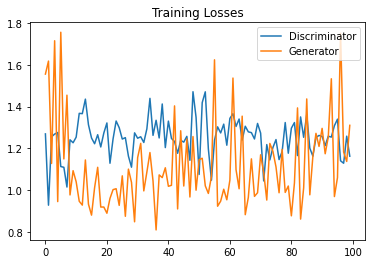

In [ ]:
#Biểu đồ hàm loss
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [ ]:
def view_samples(epoch, samples):
  fig, axes = plt.subplots(figsize=(7,7), nrows = 4, ncols = 4, sharey = True, sharex = True)
  for ax, img in zip(axes.flatten(), samples[epoch]):
    img = img.detach()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((28,28)), cmap = 'Greys_r')

In [ ]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

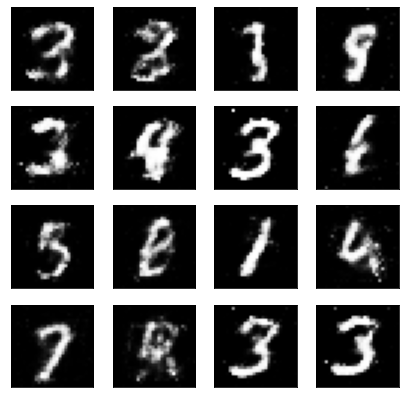

In [ ]:
view_samples(-1, samples)

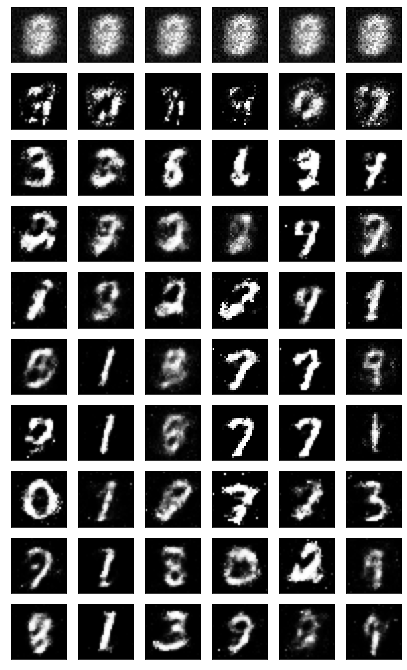

In [ ]:
rows = 10
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


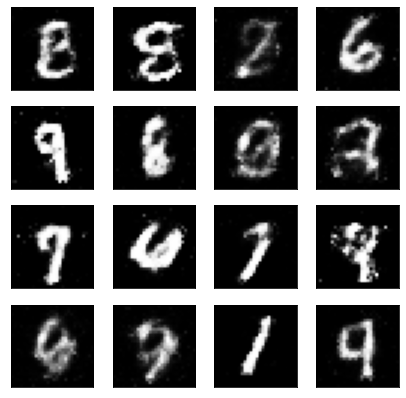

In [ ]:
sample_size = 16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval()
rand_images = G(rand_z)
view_samples(0, [rand_images])

In [ ]:
#GAN trên bộ dữ liệu MNIST-FASHION sử dụng PYTORCH
from torchvision.datasets import FashionMNIST

mnist_f = FashionMNIST(root='data', train = True, download = True, transform = transform)

trainloader_f = torch.utils.data.DataLoader(mnist_f, batch_size = batch_size, num_workers = num_workers)

In [ ]:
import pickle as pkl

num_epochs = 200

samples = []
losses = []

print_every = 400

sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(trainloader_f):
                
        batch_size = real_images.size(0)
        
        real_images = real_images*2 - 1  
        
        d_optimizer.zero_grad()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)
               
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        g_optimizer.zero_grad()

        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        

        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) 
        
     
        g_loss.backward()
        g_optimizer.step()

        if batch_i % print_every == 0:
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    losses.append((d_loss.item(), g_loss.item()))
    
    G.eval() 
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() 

with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  200] | d_loss: 9.3394 | g_loss: 1.5321
Epoch [    1/  200] | d_loss: 1.1996 | g_loss: 2.4266
Epoch [    1/  200] | d_loss: 1.0708 | g_loss: 1.4621
Epoch [    1/  200] | d_loss: 0.9824 | g_loss: 1.7561
Epoch [    1/  200] | d_loss: 0.9672 | g_loss: 1.5671
Epoch [    2/  200] | d_loss: 1.1274 | g_loss: 1.5045
Epoch [    2/  200] | d_loss: 1.2576 | g_loss: 1.2762
Epoch [    2/  200] | d_loss: 1.1221 | g_loss: 1.2529
Epoch [    2/  200] | d_loss: 1.2291 | g_loss: 1.3355
Epoch [    2/  200] | d_loss: 1.2969 | g_loss: 0.9081
Epoch [    3/  200] | d_loss: 0.8218 | g_loss: 1.2810
Epoch [    3/  200] | d_loss: 1.2788 | g_loss: 1.7222
Epoch [    3/  200] | d_loss: 1.2963 | g_loss: 1.1613
Epoch [    3/  200] | d_loss: 1.1145 | g_loss: 1.2508
Epoch [    3/  200] | d_loss: 1.3159 | g_loss: 1.1642
Epoch [    4/  200] | d_loss: 1.0325 | g_loss: 1.3952
Epoch [    4/  200] | d_loss: 1.3870 | g_loss: 1.3707
Epoch [    4/  200] | d_loss: 1.2378 | g_loss: 1.0981
Epoch [    4/  200] | d_loss

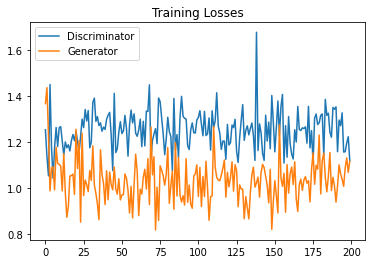

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

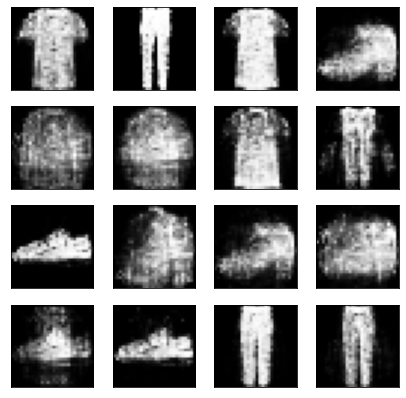

In [ ]:
view_samples(-1, samples)

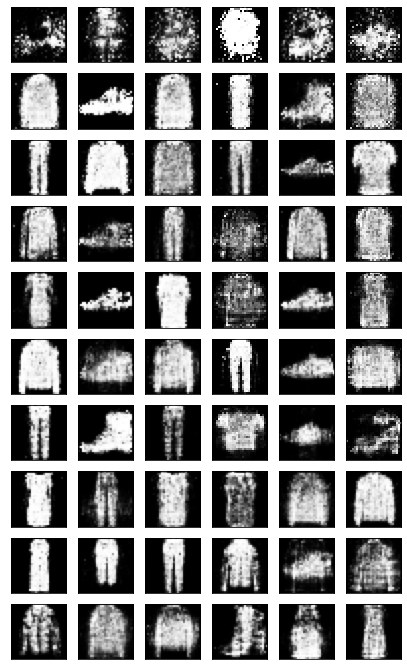

In [ ]:
rows = 10 
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


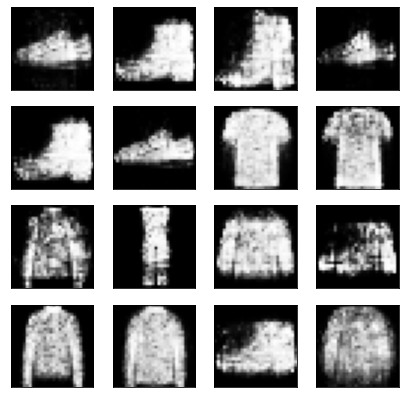

In [ ]:
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() 
rand_images = G(rand_z)

view_samples(0, [rand_images])